SECOND ASSIGNMENT: **PREDICTING EMPLOYEE ATTRITION/BURNOUT** \
AUTHORS : **AHMAD ALOBAID, YOUSSEF BENSLIMANE**

# 1. Simplified EDA
We set the seed to the student id formula given in the exercise, which is 4. We start by exploring the data and we start by printing the info and the head of dataframe we created from the data stored in the csv file `attrition_availabledata_04.csv`. We explore the number of features, their types and the number of data points. We also check if there are any missing values and explore which features are categorical and which are numeric. Some are automatically loaded as object, and we converted them to a categorical type. We check for columns which have the same value for all the data points and we remove them as they do not add any useful information for the training and prediction.

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

student_id = 4
random.seed(student_id)
np.random.seed(student_id)

data = pd.read_csv("attrition_availabledata_04.csv")

# Display the structure of the dataset
print("Info: ")
print(data.info())
print("Head: ")
print(data.head())

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   float64
 2   JobInvolvement           2940 non-null   float64
 3   PerformanceRating        2940 non-null   float64
 4   EnvironmentSatisfaction  2940 non-null   float64
 5   JobSatisfaction          2940 non-null   float64
 6   WorkLifeBalance          2940 non-null   float64
 7   Age                      2940 non-null   float64
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   float64
 11  Education                2940 non-null   float64
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   float64
 14  EmployeeID       

In [2]:
# Basic information about the data
print("Shape of the dataset:", data.shape)
print(f"# features: {data.shape[1]}")
print(f"# data points: {data.shape[0]}")
print("Data Types:\n", data.dtypes.value_counts())
print("Missing Values:\n", data.isnull().sum())

# Constant columns
constant_cols = [col for col in data.columns if data[col].nunique() == 1]
print("Constant Columns:", constant_cols)

# ID columns
id_cols = ["EmployeeID"]
print("Constant Columns:", id_cols)

# Check the target variable distribution
attrition_dist = data["Attrition"].value_counts(normalize=True) * 100
print("Attrition Class Distribution:\n", attrition_dist)

# Drop constant columns
data_cleaned = data.drop(columns=constant_cols+id_cols)

Shape of the dataset: (2940, 31)
# features: 31
# data points: 2940
Data Types:
 float64    23
object      8
Name: count, dtype: int64
Missing Values:
 hrs                        0
absences                   0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
Age                        0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
YearsAtCompany             0
YearsSinceLastPromotion    0
YearsWi

Through our data summary, we notice that it contains `2940` instances and `31` attributes and no missing values in all 31 columns.
## 1.1 Data type
### Numerical variables :
We have overall 23 numerical variables, which are :
- `hrs`
- `absences`
- `JobInvolvement`
- `PerformanceRating`
- `EnvironmentSatisfaction`
- `JobSatisfaction`
- `WorkLifeBalance`
- `Age`
- `DistanceFromHome`
- `Education`
- `EmployeeCount` 
- `EmployeeID` 
- `JobLevel`
- `MonthlyIncome`
- `NumCompaniesWorked`
- `PercentSalaryHike`
- `StandardHours` 
- `StockOptionLevel`
- `TotalWorkingYears`
- `TrainingTimesLastYear`
- `YearsAtCompany`
- `YearsSinceLastPromotion`
- `YearsWithCurrManager`
### Categorical variables :
There are 8 categories in our data, that can be grouped according to the question :
- `BusinessTravel`
- `Department`
- `EducationField`
- `Gender`
- `JobRole`
- `MaritalStatus`
- `Over18`
- `Attrition` 

## 1.2 Categorical variables with high cardinality :
2 variables have relatively large number of unique categories, which would make modeling more complex :
- `JobRole` : has 9 categories
- `EducationField` has 6 categories


In [3]:
print(f"{'name':15} {'ratio'} {'Cardinality':3} {'Frequencies'}")

for cname in data_cleaned.columns:
    if data_cleaned[cname].dtype != np.float64:
        data_cleaned[cname] = data_cleaned[cname].astype("category")
        ccounts = data_cleaned[cname].value_counts()
        max_count = ccounts.max()
        min_count = ccounts.min()
        un_balance = (max_count - min_count) / max_count
        cardinality = data_cleaned[cname].nunique()  # Calculate cardinality
        categories_frequencies = ', '.join(f"{cat}: {count}" for cat, count in ccounts.items())
        print(f"{cname:15} {un_balance:.2f} {cardinality:12} {categories_frequencies}")


name            ratio Cardinality Frequencies
BusinessTravel  0.85            3 Travel_Rarely: 2063, Travel_Frequently: 564, Non-Travel: 313
Department      0.94            3 Research & Development: 1919, Sales: 899, Human Resources: 122
EducationField  0.96            6 Life Sciences: 1223, Medical: 906, Marketing: 315, Technical Degree: 272, Other: 169, Human Resources: 55
Gender          0.34            2 Male: 1767, Female: 1173
JobRole         0.83            9 Sales Executive: 634, Research Scientist: 591, Laboratory Technician: 511, Manufacturing Director: 303, Healthcare Representative: 261, Manager: 203, Sales Representative: 167, Research Director: 165, Human Resources: 105
MaritalStatus   0.52            3 Married: 1358, Single: 930, Divorced: 652
Attrition       0.81            2 No: 2466, Yes: 474



## 1.3 Features with missing values :
None

## 1.4 Constant columns or ID columns :
### Constant columns :
3 constant columns with one value and could be removed from our data :
- `Over18` 
- `EmployeeCount`
- `StandardHours`
### ID columns :
- `EmployeeID` : is a unique identifier and should be removed and excluded from modeling as it doesn't help in predicting the target.

## 1.5 Problem type and imbalance :
It is a classification problem, where `Attrition` is our target variable. It is likely imbalanced, since we have `83.88%` "No" and `16.12%` "Yes" in our response variable.

## 1.6 Additional considerations :
- High cardinality variables should be handled, as they may lead to overfitting if not handled properly.
- We have redundancy in our data; constant columns are dropped as they are useless for predicting teh 
- We most likely need to resample or class weight adjust our response variable, in order to manage the imbalance in our target. 

# 2. Data setup
We prepare the data for the inner evaluation and split the data into training and testing data. We also stratify to have a balance response.

## 2.1 Data split 
We split the data into training (80%) and testing (20%) sets.

Training set shape: (2352, 26)
Test set shape: (588, 26)


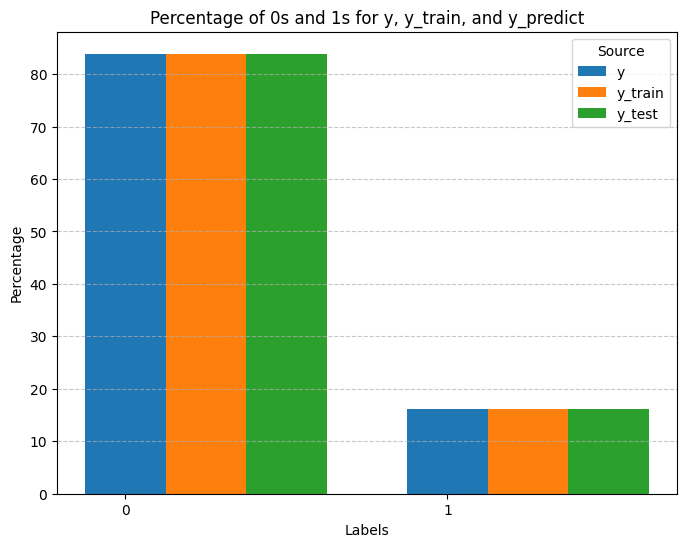

In [4]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = data_cleaned.drop(columns=["Attrition"])
y = data_cleaned["Attrition"].map({"Yes": 1, "No": 0})

# Spliting the data into training and testing test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=student_id, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



def calculate_percentages(data, name):
    counts = pd.Series(data).value_counts(normalize=True) * 100
    return {
        'Label': [0, 1],
        'Percentage': [counts.get(0, 0), counts.get(1, 0)],
        'Source': name
    }

# Calculate percentages for y, y_train, and y_predict
data = pd.concat([
    pd.DataFrame(calculate_percentages(y, 'y')),
    pd.DataFrame(calculate_percentages(y_train, 'y_train')),
    pd.DataFrame(calculate_percentages(y_test, 'y_test'))

])

# Create the bar plot
plt.figure(figsize=(8, 6))
for source in data['Source'].unique():
    subset = data[data['Source'] == source]
    plt.bar(subset['Label'] + (0.25 * list(data['Source'].unique()).index(source)),
            subset['Percentage'],
            width=0.25,
            label=source)

# Customize the plot
plt.xticks([0, 1], ['0', '1'])
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.title('Percentage of 0s and 1s for y, y_train, and y_predict')
plt.legend(title='Source')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2.2 Step for inner evaluation :

- For inner evaluation, we'd use `3-fold-cross-validation` for computational efficiency. It would allow us to divide the training set into 3 folds; 2 for training and 1 for validation in each iteration
- As for the workflow, we'd apply the method across all models and hyperparameter tuning tasks for consistency
- We'd then go for cross validation to reduce the risk of overfitting
- Finally, we'd choose a metric suited for the problem. We would choose the balanced accuracy metric which is suitable for unbalanced data [1](https://support.sas.com/resources/papers/proceedings17/0942-2017.pdf), [2](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html).


# 3. Basic Methods: Decision Tree and KNN

## 3.1 Training and Evaluation with default parameters
- We'd compare two basic methods (Decision trees and KNN) with default hyperparameters alongside `DummyClassifier`
- For KNN, we compare two scaling methods (StandardScaling vs MinMaxScaler)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from IPython.display import display
import pandas as pd
import numpy as np
import time



# Preprocessings
categorical_cols = X_train.select_dtypes(include=["category"]).columns
numerical_cols = X_train.select_dtypes(exclude=["category"]).columns

# Define preprocessors
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler()
}

# Models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=student_id),
    "KNN": KNeighborsClassifier(),
    "Dummy": DummyClassifier(strategy="most_frequent"),
}

# Baseline evaluation with default hyperparameters
results = []
for scaler_name, scaler in scalers.items():
    for model_name, model in models.items():
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", scaler, numerical_cols),
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ]
        )
        pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
        
        # Measure training time
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluate
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        
        # Save results
        results.append({
            "Scaler": scaler_name,
            "Model": model_name,
            "Accuracy": acc,
            "Balanced Accuracy": bal_acc,
            "Training Time (s)": training_time,
        })

results_df = pd.DataFrame(results)
print("Baseline Results:")
display(results_df)
avg_training_time = results_df["Training Time (s)"].mean()
print(f"Mean Training time: {avg_training_time:.4f}")

Baseline Results:


,Scaler,Model,Accuracy,Balanced Accuracy,Training Time (s)
0,StandardScaler,Decision Tree,0.928571,0.868176,0.017326
1,StandardScaler,KNN,0.865646,0.647945,0.003627
2,StandardScaler,Dummy,0.838435,0.500000,0.004526
3,MinMaxScaler,Decision Tree,0.928571,0.868176,0.017838
4,MinMaxScaler,KNN,0.831633,0.597918,0.003864
5,MinMaxScaler,Dummy,0.838435,0.500000,0.003787


Mean Training time: 0.0085


## 3.2 Training and Evaluation with Hyper Parameter Tuning
In this section, we tune the hyper parameters for the KNN (n_neighbors) and Decision Tree (max_depth). Note that for KNN, we started the n_neighbors from 3 to avoid overfitting (optimal k=1 might be a sign of overfitting). For the Decision Tree, we stopped at max_depth=21 as the scores does not change much as the value increase beyond that. 

In [6]:
# Hyperparameter tuning
param_grid_knn = {"model__n_neighbors": list(range(3, 10, 1))}
param_grid_tree = {"model__max_depth": list(range(3, 22, 1)) + [None]}

# GridSearchCV for KNN
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)
knn_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", KNeighborsClassifier())])
grid_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=3, scoring="balanced_accuracy", n_jobs=-1)
start_time = time.time()
grid_knn.fit(X_train, y_train)
knn_grid_training_time = time.time() - start_time

# GridSearchCV for Decision Tree
tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeClassifier(random_state=student_id))])
grid_tree = GridSearchCV(tree_pipeline, param_grid_tree, cv=3, scoring="balanced_accuracy", n_jobs=-1)
start_time = time.time()
grid_tree.fit(X_train, y_train)
tree_grid_training_time = time.time() - start_time


# Compare HPO results
print("Best Parameters for KNN:", grid_knn.best_params_)
print("Best Parameters for Decision Tree:", grid_tree.best_params_)
print("Best Balanced Accuracy for KNN (inner):", grid_knn.best_score_)
print("Best Balanced Accuracy for Decision Tree (inner):", grid_tree.best_score_)

final_knn = grid_knn.best_estimator_
final_tree = grid_tree.best_estimator_

knn_test_acc = balanced_accuracy_score(y_test, final_knn.predict(X_test))
tree_test_acc = balanced_accuracy_score(y_test, final_tree.predict(X_test))

print("Final KNN Test Accuracy (outer):", knn_test_acc)
print("Final Decision Tree Test Accuracy (outer):", tree_test_acc)

df_time = pd.DataFrame({
 "Training": ["Mean Training time with default values", "Training time with HPO for KNN",
              "Training time with HPO for Decision Tree", "Training time difference with KNN", 
              "Training time difference with Decision Tree"],
 "Time (in seconds)": [round(avg_training_time, 4), round(knn_grid_training_time, 4), round(tree_grid_training_time, 4),
                      round(knn_grid_training_time-avg_training_time, 4), round(tree_grid_training_time-avg_training_time, 4)]
})
display(df_time)

Best Parameters for KNN: {'model__n_neighbors': 3}
Best Parameters for Decision Tree: {'model__max_depth': 16}
Best Balanced Accuracy for KNN (inner): 0.6357446296090479
Best Balanced Accuracy for Decision Tree (inner): 0.7857326909478782
Final KNN Test Accuracy (outer): 0.7807302231237323
Final Decision Tree Test Accuracy (outer): 0.8754670652289954


,Training,Time (in seconds)
0,Mean Training time with default values,0.0085
1,Training time with HPO for KNN,1.0452
2,Training time with HPO for Decision Tree,0.2256
3,Training time difference with KNN,1.0367
4,Training time difference with Decision Tree,0.2171


- Does HPO improve the results? Yes it does. For KNN the score improved from 0.6479 to 0.7807 and for the decision tree the score improved from 0.8682 to 0.8754. 
- What is the computation cost? The GridSearch looks for all different possible combinations for the parameter values, which can take a lot of time depending on the problem settings, possible values, and the data used. Running this on different machines varies. Generally, the difference between tunning KNN and using the default parameter values (mean of the different models) is around 0.01 seconds and around 0.29 seconds for decision trees. 
- Which HPO technique obtaines the best results? In this problem, we used GridSearchCV, which by definition would outperform the Random Search as it would check all possibilities while the Random Search will only check partof it. However, the Random Search is faster as it test only a subset of the possibilities. Using the GridSearchCV, we found that Decision Tree out performs KNN. It also outperforms KNN with the default settings too.

# 4. Results and Final Model
## 4.1 Inner evaluation

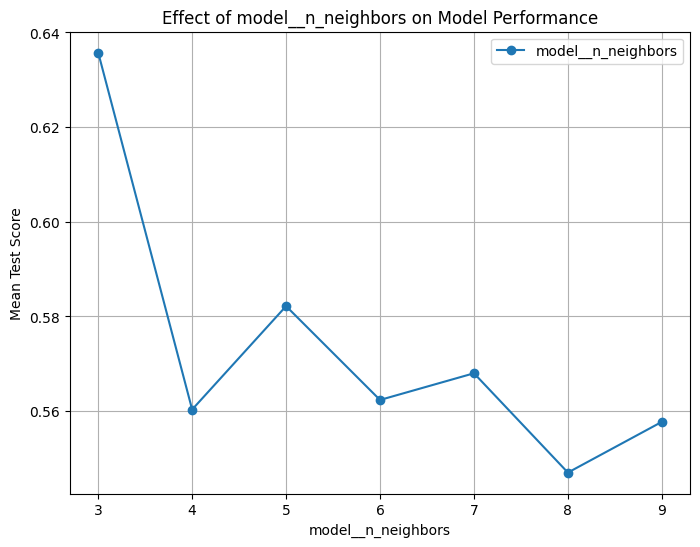

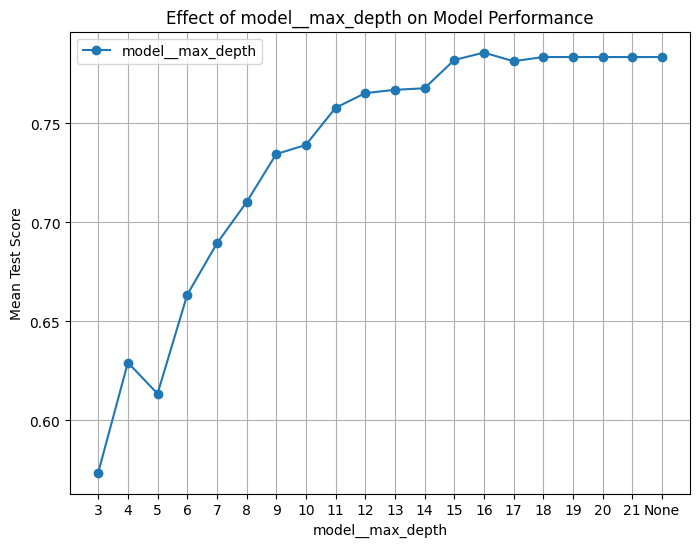

In [7]:
# Code to check the best inner evaluation and report all of them

def plot_param_scores(grid_search):
    # Get CV results
    cv_results = grid_search.cv_results_

    # Automatically fetch the parameter name
    param_names = list(cv_results['params'][0].keys())
    if len(param_names) != 1:
        raise ValueError(f"Multiple parameters found: {param_names}. Please specify which one to plot.")
    param_name = param_names[0]

    # Extract the parameter values and corresponding scores
    param_values = []
    mean_test_scores = []

    for params, mean_score in zip(cv_results['params'], cv_results['mean_test_score']):
        value = params[param_name]
        # Replace None with a label for plotting
        param_values.append("None" if value is None else value)
        mean_test_scores.append(mean_score)

    # Plot the scores
    plt.figure(figsize=(8, 6))
    plt.plot(param_values, mean_test_scores, marker='o', label=f'{param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title(f'Effect of {param_name} on Model Performance')
    plt.grid(True)
    plt.legend()
    plt.show()


plot_param_scores(grid_knn)
plot_param_scores(grid_tree)

The best inner evaluation: 
- For the KNN, the best value is with k=3 and the performance drops significantly after that.
- max_depth increases as the max_depth values increase and peaks at max_depth=19 and starts to declines after that. 

## 4.2 Outer evaluation
note that for the scoring we used balanced_accuracy which is more approperiate if we are evalut

In [8]:
# Evaluate the best models on the test set

print(f"Final KNN Test Accuracy (Outer): {knn_test_acc:.4f}")
print(f"Final Decision Tree Test Accuracy (Outer): {tree_test_acc:.4f}")
print("Best Parameters for KNN:", grid_knn.best_params_)
print("Best Parameters for Decision Tree:", grid_tree.best_params_)

best_model = None
best_acc = None
best_params = None
if tree_test_acc > knn_test_acc:
    best_model = "Decision Tree"
    best_acc = tree_test_acc
    best_params = grid_tree.best_params_
else:
    best_model = "KNN"
    best_acc = knn_test_acc
    best_params = grid_knn.best_params_

best_params_key = next(iter(best_params))
best_params_val = best_params[best_params_key]
best_params_name = best_params_key.split("__")[-1] 
print(f"The best model is: {best_model} with {best_params_name}={best_params_val} and balanced accuracy: {best_acc:.2f}")

Final KNN Test Accuracy (Outer): 0.7807
Final Decision Tree Test Accuracy (Outer): 0.8755
Best Parameters for KNN: {'model__n_neighbors': 3}
Best Parameters for Decision Tree: {'model__max_depth': 16}
The best model is: Decision Tree with max_depth=16 and balanced accuracy: 0.88


## 4.3 Final Model

We do not pick the model suggested by the GridSearch as there was a sign on overfitting as the increase in accuracy is very small as the depth increase. This can be noticed from the previously depicted graph. Hence, we choose our final model to be with max_depth=15. 
We use this settings to create the final model by training it on the whole dataset what we have (available data). The final model is saved using the [joblib](https://joblib.readthedocs.io/en/stable/) library (if it is not yet saved). We use the final model to predict the competition data. Note that the model is not trained on the competition data. Besides that, we inspect the competition data and check for missing values (we did not find any) and show some meta data (e.g., number of features, datapoints, types).

In [9]:
import joblib
import os

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeClassifier(random_state=student_id, max_depth=15))])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"final model balanced accuracy: {bal_acc:.4f}")

output_file = "final_model.joblib"
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeClassifier(random_state=student_id, max_depth=15))])
pipeline.fit(X, y)
if not os.path.exists(output_file):
    with open(output_file, 'wb') as fo:
        print("Generating the final model joblib")
        joblib.dump(pipeline, fo)
else:
    print("final model already exists.")
with open(output_file, 'rb') as fo:  
    final_model = joblib.load(fo)


# load the competition data and 
comp_data = pd.read_csv("attrition_competition_04.csv")

# Basic information about the data
print("Shape of the dataset:", comp_data.shape)
print(f"# features: {comp_data.shape[1]}")
print(f"# data points: {comp_data.shape[0]}")
print("Data Types:\n", comp_data.dtypes.value_counts())
print("Missing Values:\n", comp_data.isnull().sum())


comp_X = comp_data.drop(columns=constant_cols+id_cols)
comp_y_pred = final_model.predict(comp_X)

for cname in comp_X.columns:
    if comp_X[cname].dtype != np.float64:
        comp_X[cname] = comp_X[cname].astype("category")

df_predictions = pd.DataFrame({
    'Row Index': range(len(comp_y_pred)),
    'Attrition': comp_y_pred
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('predictions.csv', index=False)
print("Predictions of the competition data are saved to predictions.csv")

final model balanced accuracy: 0.8649
Generating the final model joblib
Shape of the dataset: (1470, 30)
# features: 30
# data points: 1470
Data Types:
 float64    23
object      7
Name: count, dtype: int64
Missing Values:
 hrs                        0
absences                   0
JobInvolvement             0
PerformanceRating          0
EnvironmentSatisfaction    0
JobSatisfaction            0
WorkLifeBalance            0
Age                        0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EmployeeCount              0
EmployeeID                 0
Gender                     0
JobLevel                   0
JobRole                    0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
Over18                     0
PercentSalaryHike          0
StandardHours              0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear 

# 6. Open Choice
For this task, we decided to use XGBoost. It stands for Extreme Gradient Boosting. It is a distributed Gradient Boosting. It uses weak learners and combine them to create a stronger classifier. Sequentially, it passes the errors (wrong predictions) for the weak classifier to the next weak classifiers. 

## 6.1 Training the Evaluation of the XGBoost Model
We used the [xgboost](https://xgboost.readthedocs.io/en/stable/index.html) library. We evaluated the XGBoost model using the same training and testing sets used for the KNN and Decision Tree models. The XGBoost model outperforms both, the Decision Tree and KNN with a balanced accuracy of 0.9287 (in comparison to 0.7688 for KNN and 0.8631 for Decision Tree). We do not use the Pipeline as there seems to be some incompatibilities when running the XGBClassifier with the scikit-learn Pipeline.

In [10]:
from xgboost import XGBClassifier

# Initialize XGBClassifier
model = XGBClassifier(objective='binary:logistic', random_state=student_id, enable_categorical=True)

# Fit the model to train data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
xgboost_bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"The prediction of the XGBoost model balanced accuracy: {xgboost_bal_acc:.4f}")

The prediction of the XGBoost model balanced accuracy: 0.9160


## 6.2 Final XGBoost Model
We train the model on the whole dataset and save the model using the library [joblib](https://joblib.readthedocs.io/en/stable/). After that, we generate a prediction of the competition data and named the file `predictions_xgboost.csv`.

In [11]:
output_file = "xgboost_model.joblib"
model = XGBClassifier(objective='binary:logistic', random_state=student_id, enable_categorical=True)
model.fit(X, y)

if not os.path.exists(output_file):
    with open(output_file, 'wb') as fo:
        print("Generating the xgboost model joblib")
        joblib.dump(model, fo)
else:
    print("xgboost model already exists.")
    
with open(output_file, 'rb') as fo:  
    final_model = joblib.load(fo)


comp_y_pred = final_model.predict(comp_X)


df_predictions = pd.DataFrame({
    'Attrition': comp_y_pred
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('xgboost_predictions.csv', index=False)
print("XGBoost Predictions of the competition data are saved to xgboost_predictions.csv")

Generating the xgboost model joblib
XGBoost Predictions of the competition data are saved to xgboost_predictions.csv


## 6.3 Addressing Imbalance
We noticed earlier that the response was not balanced. There are multiple ways of addressing it. For KNN, some suggested the use of weighted distances giving more weight to closer neighbours [3](https://pmc.ncbi.nlm.nih.gov/articles/PMC7206335/), others reported that the use of under-sampling out-performed other sampling methods [4](https://www.scirp.org/html/3-9601307_60996.htm). For Decision Tree, imbalance can favor high frequency classes, hence weighting classes inversely by their frequencies is used to reduce the side effect of imbalance data [5](https://ieeexplore.ieee.org/abstract/document/1000348?casa_token=GEXyzXgOg7sAAAAA:7w-xtRcAn3qaHk0rNMYvowes-c9wU6kIExob70Eu2_NIHeWQggkARxiWu4Wa--rwJ_vCZWMPTQ). Other sampling techniques are left for future work.

Best Parameters for KNN: {'model__n_neighbors': 3}
Best Parameters for Decision Tree: {'model__max_depth': 17}
Best Balanced Accuracy for KNN (inner): 0.7846612804993663
Best Balanced Accuracy for Decision Tree (inner): 0.7933792079303018
Final KNN Test Accuracy (outer): 0.9182021992099925
Final Decision Tree Test Accuracy (outer): 0.8685598377281947


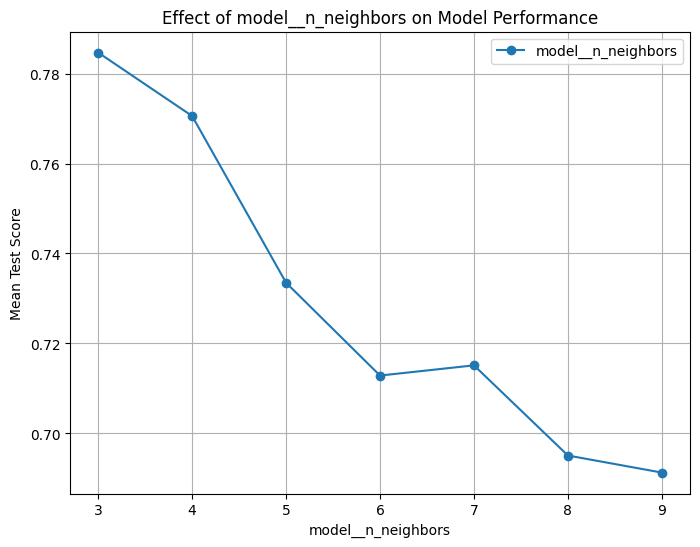

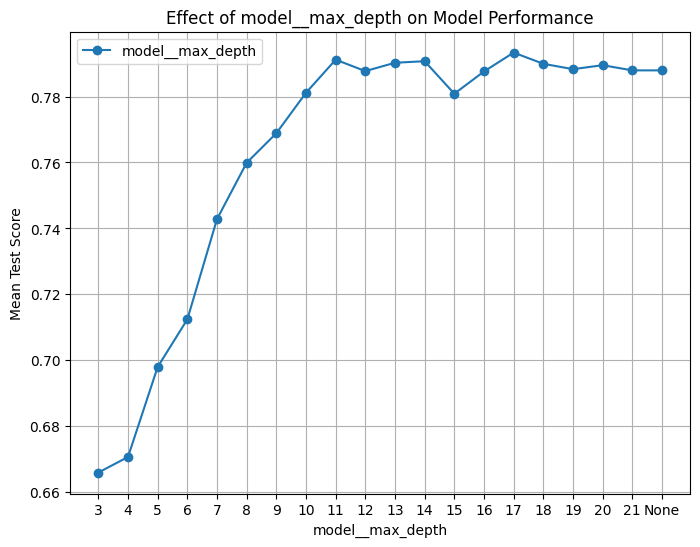

,Balanced Accuracy,Model
0,0.780730,KNN (uniform weights)
1,0.875467,Decision Tree ()
2,0.918202,KNN (distance weights)
3,0.868560,Decision Tree (w)
4,0.915982,XGBoost


In [12]:
knn_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", KNeighborsClassifier(weights='distance'))])
grid_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=3, scoring="balanced_accuracy", n_jobs=-1)
grid_knn.fit(X_train, y_train)

# GridSearchCV for Decision Tree
tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", DecisionTreeClassifier(random_state=student_id, class_weight="balanced"))])
grid_tree = GridSearchCV(tree_pipeline, param_grid_tree, cv=3, scoring="balanced_accuracy", n_jobs=-1)
grid_tree.fit(X_train, y_train)


# Compare HPO results
print("Best Parameters for KNN:", grid_knn.best_params_)
print("Best Parameters for Decision Tree:", grid_tree.best_params_)
print("Best Balanced Accuracy for KNN (inner):", grid_knn.best_score_)
print("Best Balanced Accuracy for Decision Tree (inner):", grid_tree.best_score_)

final_knn_imb = grid_knn.best_estimator_
final_tree_imb = grid_tree.best_estimator_

knn_imb_test_acc = balanced_accuracy_score(y_test, final_knn_imb.predict(X_test))
tree_imb_test_acc = balanced_accuracy_score(y_test, final_tree_imb.predict(X_test))

print("Final KNN Test Accuracy (outer):", knn_imb_test_acc)
print("Final Decision Tree Test Accuracy (outer):", tree_imb_test_acc)

plot_param_scores(grid_knn)
plot_param_scores(grid_tree)
df_results_with_imb = pd.DataFrame({
    "Balanced Accuracy": [knn_test_acc, tree_test_acc, knn_imb_test_acc, tree_imb_test_acc, xgboost_bal_acc],
    "Model": ["KNN (uniform weights)", "Decision Tree ()", "KNN (distance weights)", "Decision Tree (w)", "XGBoost"]
})
display(df_results_with_imb)

# 7. The use of AI
we used chatGPT to help us fix some of the errors we encountered with the use of pipelines and XGBoost. It also used it to double check our interpretation and understanding. We also used it to bounce and brainstorm some ideas (e.g., treating data imbalance technique). It was also helpful for writing the code to draw the figures.

# References
1.  Akosa, Josephine. "Predictive accuracy: A misleading performance measure for highly imbalanced data." Proceedings of the SAS global forum. Vol. 12. Cary, NC, USA: SAS Institute Inc., 2017.
2.  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
3. Kadir, Md Eusha, et al. "A proximity weighted evidential k nearest neighbor classifier for imbalanced data." Advances in Knowledge Discovery and Data Mining: 24th Pacific-Asia Conference, PAKDD 2020, Singapore, May 11–14, 2020, Proceedings, Part II 24. Springer International Publishing, 2020.
4. Beckmann, Marcelo, Nelson FF Ebecken, and Beatriz SL Pires De Lima. "A KNN undersampling approach for data balancing." Journal of Intelligent Learning Systems and Applications 7.4 (2015): 104-116.
5. Ting, Kai Ming. "An instance-weighting method to induce cost-sensitive trees." IEEE Transactions on Knowledge and Data Engineering 14.3 (2002): 659-665.